# Scikit-learn 배우기: 파이썬과 기계 학습

## 4장 : 고급 기능 -  모델 선택(Model Selection)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.datasets import fetch_20newsgroups

news = fetch_20newsgroups(subset='all')

n_samples = 3000

X = news.data[:n_samples]
y = news.target[:n_samples]

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
def get_stop_words():
    result = set()
    for line in open('stopwords_en.txt', 'r').readlines():
        result.add(line.strip())
    return result

stop_words = get_stop_words()

clf = Pipeline([
    ('vect', TfidfVectorizer(
                stop_words=stop_words,
                token_pattern=ur"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",         
    )),
    ('nb', MultinomialNB(alpha=0.01)),
])

In [5]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # k-중첩 교차 검증 생성기를 만든다
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # 기본적으로 점수 함수는 에스터메이터의 점수 함수로 반환된 함수를 사용한다(정확도)
    scores = cross_val_score(clf, X, y, cv=cv)
    print scores
    print ("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), sem(scores))

In [6]:
evaluate_cross_validation(clf, X, y, 3)

[ 0.812  0.808  0.822]
Mean score: 0.814 (+/-0.004)


In [7]:
def calc_params(X, y, clf, param_values, param_name, K):
    # 0으로 훈련과 테스트 점수 배열을 초기화한다
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # 매개 변수 값만큼 반복한다
    for i, param_value in enumerate(param_values):
        print param_name, ' = ', param_value
        
        # 분류기 매개 변수를 설정한다
        clf.set_params(**{param_name:param_value})
        
        # 각 중첩에 대한 K 점수 배열을 초기화한다
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # KFold 교차 검증 생성한다
        cv = KFold(n_samples, K, shuffle=True, random_state=0)
        
        # K 중첩만큼 반복한다
        for j, (train, test) in enumerate(cv):
            # 훈련과 테스트 데이테로 중첩 분류기에 적합화하고 정확도를 구한다
            clf.fit([X[k] for k in train], y[train])
            k_train_scores[j] = clf.score([X[k] for k in train], y[train])
            k_test_scores[j] = clf.score([X[k] for k in test], y[test])
            
        # K 중첩 점수의 평균을 저장한다
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
       
    # 로그 스케일로 훈련 데이터와 테스트 데이터를 그린다
    plt.semilogx(param_values, train_scores, alpha=0.4, lw=2, c='b')
    plt.semilogx(param_values, test_scores, alpha=0.4, lw=2, c='g')
    
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    # 매개 변수에 대한 훈련과 테스트 점수를 반환한다
    return train_scores, test_scores

In [8]:
alphas = np.logspace(-7, 0, 8)
print alphas

[  1.00000000e-07   1.00000000e-06   1.00000000e-05   1.00000000e-04
   1.00000000e-03   1.00000000e-02   1.00000000e-01   1.00000000e+00]


nb__alpha  =  1e-07
nb__alpha  =  1e-06
nb__alpha  =  1e-05
nb__alpha  =  0.0001
nb__alpha  =  0.001
nb__alpha  =  0.01
nb__alpha  =  0.1
nb__alpha  =  1.0


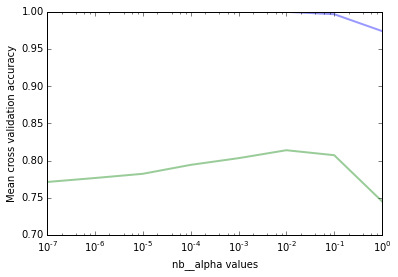

In [9]:
train_scores, test_scores = calc_params(X, y, clf, alphas, 'nb__alpha', 3)

In [10]:
print 'training scores: ', train_scores
print 'testing scores: ', test_scores

training scores:  [ 1.          1.          1.          1.          1.          1.
  0.99683333  0.97416667]
testing scores:  [ 0.77133333  0.77666667  0.78233333  0.79433333  0.80333333  0.814
  0.80733333  0.74533333]


In [11]:
from sklearn.svm import SVC

clf = Pipeline([
    ('vect', TfidfVectorizer(
                stop_words=stop_words,
                token_pattern=ur"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",         
    )),
    ('svc', SVC()),
])

In [ ]:
gammas = np.logspace(-2, 1, 4)

train_scores, test_scores = calc_params(X, y, clf, gammas, 'svc__gamma', 3)

svc__gamma  =  0.01
svc__gamma  =  0.1
svc__gamma

In [13]:
print 'training scores: ', train_scores
print 'testing scores: ', test_scores

training scores:  [ 0.06183333  0.279       0.99966667  1.        ]
testing scores:  [ 0.04866667  0.162       0.74666667  0.05166667]


감마(gamma) < 1에 대하여 과소적합화를 겪는다. 감마 > 1에 대해서, 과적합화를 겪는다. 최적의 결과는 감마 = 1로서 훈련 정확도는 0.999과 테스트 정확도는 0.760을 얻는다.

In [14]:
from sklearn.grid_search import GridSearchCV

parameters = {
    'svc__gamma': np.logspace(-2, 1, 4),
    'svc__C': np.logspace(-1, 1, 3),
}

clf = Pipeline([
    ('vect', TfidfVectorizer(
                stop_words=stop_words,
                token_pattern=ur"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",         
    )),
    ('svc', SVC()),
])

gs = GridSearchCV(clf, parameters, verbose=2, refit=False, cv=3)

In [15]:
from sklearn.externals import joblib
from sklearn.cross_validation import ShuffleSplit
import os

def persist_cv_splits(X, y, K=3, name='data', suffix="_cv_%03d.pkl"):
    """K 중첩을 파일에 저장한다."""
    
    cv_split_filenames = []
    
    # KFold 교차 검증 생성한다
    cv = KFold(n_samples, K, shuffle=True, random_state=0)
    
    # K 중첩만큼 반복한다
    for i, (train, test) in enumerate(cv):
        cv_fold = ([X[k] for k in train], y[train], [X[k] for k in test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

In [16]:
%time _ = gs.fit(X, y)

gs.best_params_, gs.best_score_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[GridSearchCV] svc__gamma=0.01, svc__C=0.1 .....................................
[GridSearchCV] ............................ svc__gamma=0.01, svc__C=0.1 -   9.5s
[GridSearchCV] svc__gamma=0.01, svc__C=0.1 .....................................
[GridSearchCV] ............................ svc__gamma=0.01, svc__C=0.1 -   9.5s
[GridSearchCV] svc__gamma=0.01, svc__C=0.1 .....................................
[GridSearchCV] ............................ svc__gamma=0.01, svc__C=0.1 -   9.3s
[GridSearchCV] svc__gamma=0.1, svc__C=0.1 ......................................
[GridSearchCV] ............................. svc__gamma=0.1, svc__C=0.1 -   9.4s
[GridSearchCV] svc__gamma=0.1, svc__C=0.1 ......................................
[GridSearchCV] ............................. svc__gamma=0.1, svc__C=0.1 -   9.1s
[GridSearchCV] svc__gamma=0.1, svc__C=0.1 ......................................
[GridSearchCV] ............................. svc

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  5.5min finished



CPU times: user 5min 30s, sys: 172 ms, total: 5min 30s
Wall time: 5min 31s


({'svc__C': 10.0, 'svc__gamma': 0.10000000000000001}, 0.82799999999999996)

격자 검색(grid search)으로 C와 감마의 좀 더 나은 조합을 구했다. C를 1.0으로 고정하고 감마만 변경했던 이전 실험에서 얻은 0.76보다 10.0의 C와 0.10의 감마로 3-중첩 교차 검증의 정확도 0.828을 얻었다.

결과를 향상하기 위해 격자 검색에서 벡터라이저의 매개 변수를 조절한다.


# 병렬(Parallelizing)

먼저, 교차 검증을 위한 k 중첩을 파일에 저장하는 함수를 선언한다. 이 파일은 해당 중첩을 실행하는 프로세스가 로드한다.

In [18]:
cv_filenames = persist_cv_splits(X, y, name='news')

다음 함수는 특정한 중첩을 로드하여 특정 매개 변수 집합으로 분류기를 적합화한다. 이후, 테스트 점수를 반환한다. 이 함수는 병렬 프로세스로부터 호출된다.


In [19]:
def compute_evaluation(cv_split_filename, clf, params):
    
    # 모든 모듈 임포트는 worker에서 실행해야 한다
    from sklearn.externals import joblib

    # 파일시스템에서 중첩 훈련과 테스트를 로드한다
    X_train, y_train, X_test, y_test = joblib.load(
        cv_split_filename, mmap_mode='c')
    
    clf.set_params(**params)
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    return test_score

이 함수는 병렬 프로세스에서 격자 검색을 실행한다. 각 매개 변수 조합에 대해(IterGrid 반복자를 반환한다), k중첩만큼 반복하고 평가하기 위해 프로세스를 생성한다. 태스크 리스트와 매개 변수 조합을 반환한다.

In [20]:
from sklearn.grid_search import IterGrid

def parallel_grid_search(lb_view, clf, cv_split_filenames, param_grid):
    
    all_tasks = []
    all_parameters = list(IterGrid(param_grid))
    
    # 매개 변수 조합만큼 반복한다
    for i, params in enumerate(all_parameters):
        task_for_params = []
        
        # K중첩만큼 반복한다
        for j, cv_split_filename in enumerate(cv_split_filenames):    
            t = lb_view.apply(
                compute_evaluation, cv_split_filename, clf, params)
            task_for_params.append(t) 
        
        all_tasks.append(task_for_params)
        
    return all_parameters, all_tasks

In [21]:
from sklearn.svm import SVC
from IPython.parallel import Client

client = Client()
lb_view = client.load_balanced_view()

all_parameters, all_tasks = parallel_grid_search(
   lb_view, clf, cv_filenames, parameters)

/home/brenden/workspace/infinity/dist/local/lib/python2.7/site-packages/sklearn/grid_search.py:148: DeprecationWarning: IterGrid was renamed to ParameterGrid and will be removed in 0.15.
  " removed in 0.15.", DeprecationWarning)


In [22]:
def print_progress(tasks):
    progress = np.mean([task.ready() for task_group in tasks
                                 for task in task_group])
    print "Tasks completed: {0}%".format(100 * progress)

In [30]:
print_progress(all_tasks)

Tasks completed: 100.0%


In [31]:
def find_bests(all_parameters, all_tasks, n_top=5):
    """다 실행 된 태스크의 평균 점수를 구한다"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
                   
    return sorted(mean_scores, reverse=True)[:n_top]

In [32]:
print find_bests(all_parameters, all_tasks)

[(0.82633333333333336, {'svc__gamma': 0.10000000000000001, 'svc__C': 10.0}), (0.78866666666666674, {'svc__gamma': 1.0, 'svc__C': 10.0}), (0.7466666666666667, {'svc__gamma': 1.0, 'svc__C': 1.0}), (0.23333333333333336, {'svc__gamma': 0.01, 'svc__C': 10.0}), (0.16200000000000001, {'svc__gamma': 0.10000000000000001, 'svc__C': 1.0})]
